In [4]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, boxcox
import matplotlib.pyplot as plt

Spearman Correlation Coefficient: 0.1063
P-value: 0.457684


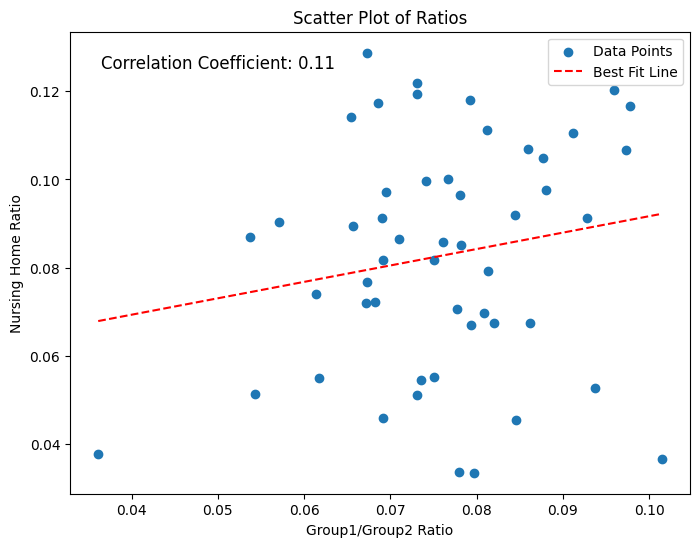

In [5]:

# Configuration Section
INPUT_CENSUS_FILE = 'census_aggregated_by_state_2020.csv'
INPUT_CMS_FILE = 'cms_aggregated_by_state_2020.csv'

# Define Group1 Ages
GROUP1_AGE = ['85 years and over']

# Define Group2 Ages (Manually Input)
GROUP2_AGE = ['45 to 49 years', '50 to 54 years', '55 to 59 years', '60 to 64 years']

# Population type to analyze
POPULATION_TYPE = 'Total population'

# Percent of residents that are in Group1
PERC_OF_RESIDENTS_THAT_ARE_IN_GROUP1 = 0.386

# Read input files
census_df = pd.read_csv(INPUT_CENSUS_FILE)
cms_df = pd.read_csv(INPUT_CMS_FILE)

# Adjust census data column names to a simpler naming convention
census_df.rename(columns={
    'Count!!SEX AND AGE!!Total population': 'Total_Population',
    'Count!!SEX AND AGE!!Male population': 'Male_Population',
    'Count!!SEX AND AGE!!Female population': 'Female_Population'
}, inplace=True)

# Merge the two dataframes on the 'State' column
df = pd.merge(census_df, cms_df, on='State', how='left')

# Convert 'total_residents' from string to float
df['total_residents'] = df['total_residents'].astype(float)

# Function to extract census age group columns for a given population type and age groups
def get_age_group_columns(df, population_type, age_groups):
    prefix = f'Count!!SEX AND AGE!!{population_type}!!'
    age_group_columns = [f'{prefix}{age}' for age in age_groups if f'{prefix}{age}' in df.columns]
    return age_group_columns

def perform_analysis():
    population_type = POPULATION_TYPE
    population_key = population_type.replace(" population", "").replace(" ", "_")
    total_population_column = f'{population_key}_Population'

    # Calculate the total number of people in GROUP1_AGE for the specified population type
    group1_columns = get_age_group_columns(df, population_type, GROUP1_AGE)
    df['Group1_Sum'] = df[group1_columns].sum(axis=1)

    # Calculate the estimated number of 85+ nursing home residents
    df['Estimated_85plus_NursingHome_Residents'] = PERC_OF_RESIDENTS_THAT_ARE_IN_GROUP1 * df['total_residents']

    # Calculate the Nursing Home Ratio (Estimated 85+ NH Residents / Total 85+ Population)
    df['NursingHome_Ratio'] = df['Estimated_85plus_NursingHome_Residents'] / df['Group1_Sum']

    # Calculate the total number of people in GROUP2_AGE for the specified population type
    group2_columns = get_age_group_columns(df, population_type, GROUP2_AGE)
    df['Group2_Sum'] = df[group2_columns].sum(axis=1)

    # Compute the ratio of Group1_Sum to Group2_Sum
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where(df['Group2_Sum'] != 0, df['Group1_Sum'] / df['Group2_Sum'], np.nan)

    # Mask invalid values
    valid_mask = ~np.isnan(ratio) & ~np.isnan(df['NursingHome_Ratio'])
    ratio = ratio[valid_mask]
    nursing_home_ratio = df['NursingHome_Ratio'][valid_mask]

    if len(ratio) > 1:
        # Compute Spearman's correlation
        corr_coef, p_value = spearmanr(ratio, nursing_home_ratio)
        print(f"Spearman Correlation Coefficient: {corr_coef:.4f}")
        print(f"P-value: {p_value:.6f}")

        # Plot the scatter plot
        plt.figure(figsize=(8,6))
        plt.scatter(ratio, nursing_home_ratio, label='Data Points')
        plt.title('Scatter Plot of Ratios')
        plt.xlabel('Group1/Group2 Ratio')
        plt.ylabel('Nursing Home Ratio')

        # Add line of best fit
        slope, intercept = np.polyfit(ratio, nursing_home_ratio, 1)
        x_vals = np.array([min(ratio), max(ratio)])
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, '--', color='red', label='Best Fit Line')

        # Annotate correlation coefficient on the plot
        plt.text(0.05, 0.95, f'Correlation Coefficient: {corr_coef:.2f}', 
                 transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

        plt.legend()
        plt.show()
    else:
        print("Not enough data points for correlation analysis.")
if __name__ == "__main__":
    perform_analysis()

Spearman Correlation Coefficient: 0.1063
P-value: 0.457684


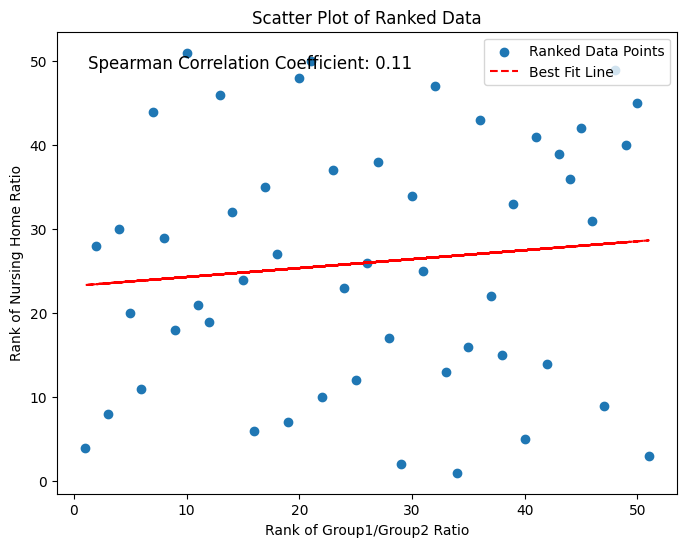

In [7]:
from scipy import stats
def perform_analysis():
    population_type = POPULATION_TYPE
    population_key = population_type.replace(" population", "").replace(" ", "_")
    total_population_column = f'{population_key}_Population'

    # Calculate the total number of people in GROUP1_AGE for the specified population type
    group1_columns = get_age_group_columns(df, population_type, GROUP1_AGE)
    df['Group1_Sum'] = df[group1_columns].sum(axis=1)

    # Calculate the estimated number of 85+ nursing home residents
    df['Estimated_85plus_NursingHome_Residents'] = PERC_OF_RESIDENTS_THAT_ARE_IN_GROUP1 * df['total_residents']

    # Calculate the Nursing Home Ratio (Estimated 85+ NH Residents / Total 85+ Population)
    df['NursingHome_Ratio'] = df['Estimated_85plus_NursingHome_Residents'] / df['Group1_Sum']

    # Calculate the total number of people in GROUP2_AGE for the specified population type
    group2_columns = get_age_group_columns(df, population_type, GROUP2_AGE)
    df['Group2_Sum'] = df[group2_columns].sum(axis=1)

    # Compute the ratio of Group1_Sum to Group2_Sum
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where(df['Group2_Sum'] != 0, df['Group1_Sum'] / df['Group2_Sum'], np.nan)

    # Mask invalid values
    valid_mask = ~np.isnan(ratio) & ~np.isnan(df['NursingHome_Ratio'])
    ratio = ratio[valid_mask]
    nursing_home_ratio = df['NursingHome_Ratio'][valid_mask]

    if len(ratio) > 1:
        # Compute Spearman's correlation
        corr_coef, p_value = spearmanr(ratio, nursing_home_ratio)
        print(f"Spearman Correlation Coefficient: {corr_coef:.4f}")
        print(f"P-value: {p_value:.6f}")

        # Compute ranks
        rank_ratio = stats.rankdata(ratio)
        rank_nursing_home_ratio = stats.rankdata(nursing_home_ratio)

        # Perform linear regression on ranks
        slope, intercept = np.polyfit(rank_ratio, rank_nursing_home_ratio, 1)

        # Plot the ranked data
        plt.figure(figsize=(8,6))
        plt.scatter(rank_ratio, rank_nursing_home_ratio, label='Ranked Data Points')
        plt.title('Scatter Plot of Ranked Data')
        plt.xlabel('Rank of Group1/Group2 Ratio')
        plt.ylabel('Rank of Nursing Home Ratio')

        # Add line of best fit on ranks
        plt.plot(rank_ratio, intercept + slope * rank_ratio, '--', color='red', label='Best Fit Line')

        # Annotate correlation coefficient on the plot
        plt.text(0.05, 0.95, f'Spearman Correlation Coefficient: {corr_coef:.2f}',
                 transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

        plt.legend()
        plt.show()
    else:
        print("Not enough data points for correlation analysis.")

if __name__ == "__main__":
    perform_analysis()
